# Statistical Methods for Machine Learning project

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform, util
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from PIL import Image
import pdb
import random
import numpy.random as npr

import math

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")

#plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [2]:
import kagglehub
import shutil

# Download latest version
path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'rockpaperscissors' dataset.
Path to dataset files: /kaggle/input/rockpaperscissors


(200, 300, 3)


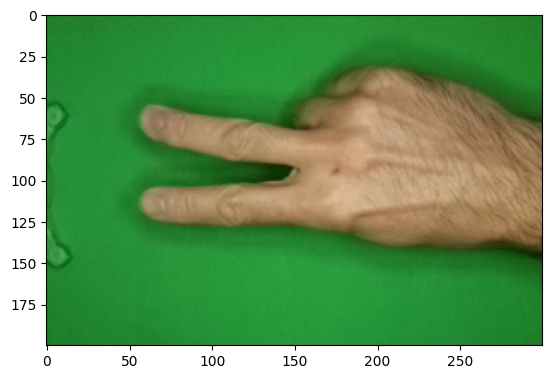

In [3]:
plt.figure()
folder = os.path.join(path, random.choice(['rock','paper','scissors']))
img_name = random.choice(os.listdir(folder))
img = io.imread(os.path.join(folder,img_name))
print( img.shape)
plt.imshow(img)
plt.show()

# Creation of training and validation folders

In [4]:
# creation of training and validation folders
ratio = 0.8
subfolders = ['rock','paper','scissors']

os.makedirs('train', exist_ok=True)
os.makedirs('val', exist_ok=True)
for subfolder in subfolders:
    subpath = os.path.join(path, subfolder)
    os.makedirs(os.path.join('train',subfolder))
    os.makedirs(os.path.join('val',subfolder))

    imgs = os.listdir(subpath)
    random.shuffle(imgs)

    train_size = int(0.8 * len(imgs))
    val_size = len(imgs) - train_size

    train_imgs = imgs[:train_size]
    val_imgs = imgs[train_size:]

    for i in train_imgs:
        shutil.copy(os.path.join(subpath,i), os.path.join('train',subfolder,i))
    for i in val_imgs:
        shutil.copy(os.path.join(subpath,i), os.path.join('val',subfolder,i))




# Transformation and data augmentation

In [5]:
# no need to resize since all images have the same dimension (?)
# validation set only transformed to tensor
# training set augmented with random transformations

val_transform = transforms.Compose([
    transforms.ToTensor()
])
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=(-20,20)),
])

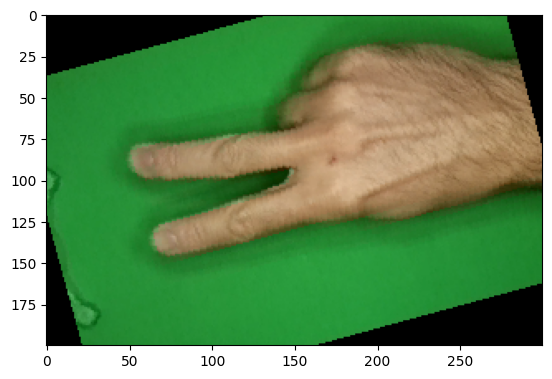

In [6]:
transformed_img = train_transform(img)
plt.imshow(transformed_img.permute(1,2,0))
plt.show()

# DataLoader creation

In [7]:
batch_size = 9
train_dataset = datasets.ImageFolder(root='train', transform=val_transform)
val_dataset = datasets.ImageFolder(root='val', transform=val_transform)

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size)

classes = train_dataset.classes

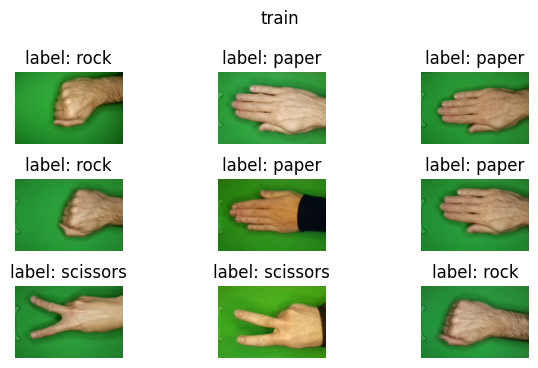

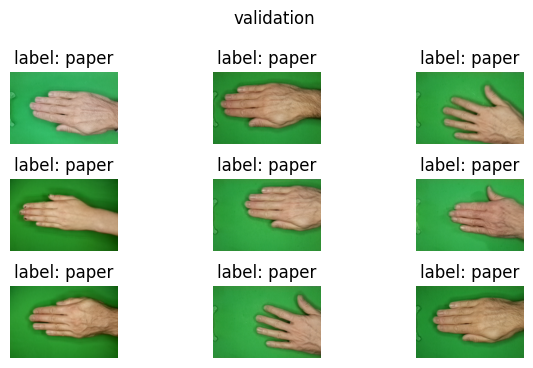

In [8]:
def show_batch(x, y, yh=None, title=None):
    col = math.floor(math.sqrt(len(x)))
    row = col+1
    for i in range(len(x)):
        ax = plt.subplot(row,col,i+1)
        plt.tight_layout()
        subtitle = 'label: ' + classes[int(y[i])]
        if (yh is not None):
            subtitle += '\nprediction: ' + classes[int(np.argmax(yh[i]))]
        ax.set_title(subtitle)
        ax.axis('off')
        plt.imshow(x[i].permute(1,2,0))
    if (title):
        plt.subplots_adjust(top=0.85)
        plt.suptitle(title)
    plt.show()

show_batch(*next(iter(train_dl)), title='train')
show_batch(*next(iter(val_dl)), title='validation')

# Training function

In [9]:
!pip install torchmetrics

In [10]:
from tqdm import tqdm
import torchmetrics
from torchmetrics import Accuracy, Precision, Recall

def train_model(model, dataloaders,  criterion, optimizer, scheduler, num_epochs=25):
    stats = {
            'train_loss': [],
            'val_loss': [],
            'val_acc': [],
            'val_rec': [],
            'val_prec': []
    }
    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)

        # TRAIN
        running_loss = 0
        for batch_index, (images, labels) in enumerate(tqdm(dataloaders['train'])):
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            running_loss += loss.item()*images.size(0)
            optimizer.step()

        epoch_loss = running_loss / len(dataloaders['train'])
        stats['train_loss'].append(epoch_loss)

        # VAL
        acc = Accuracy(task="multiclass",num_classes=len(classes)).to(device)
        precision = Precision(task="multiclass", num_classes=len(classes), average='macro').to(device)
        recall = Recall(task="multiclass", num_classes=len(classes), average='macro').to(device)

        model.eval()
        with torch.no_grad():
            for images, labels in dataloaders['val']:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()*images.size(0)
                _, preds = torch.max(outputs, 1)
                acc(preds, labels)
                precision(preds, labels)
                recall(preds, labels)

            val_loss = running_loss / len(dataloaders['val'])
            test_accuracy = acc.compute()
            test_precision = precision.compute()
            test_recall = recall.compute()

            stats['val_loss'].append(val_loss)
            stats['val_acc'].append(test_accuracy.to('cpu'))
            stats['val_rec'].append(test_recall.to('cpu'))
            stats['val_prec'].append(test_precision.to('cpu'))


        print(f"Train loss: {epoch_loss:.4f}")
        print(f"Test loss: {val_loss:.4f}")
        print(f"Test accuracy: {test_accuracy:.4f}")
        print(f"Test precision: {test_precision:.4f}")
        print(f"Test recall: {test_recall:.4f}")

    plt.plot(stats['train_loss'], 'bo-', label='train loss')
    plt.plot(stats['val_loss'], 'r+-', label='val loss')
    plt.show()

    plt.plot(stats['val_acc'])
    plt.plot(stats['val_rec'])
    plt.plot(stats['val_prec'])
    plt.show()

# Graph function

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def cm_plot(model, dl):
    y = []
    y_hat = []
    classes = dl.dataset.classes

    with torch.set_grad_enabled(False):
        for img, lbls in dl:
            output = net(img.to(device).float()).to('cpu').float()
            y.extend(lbls)
            pred = output.data.max(1, keepdim=True)[1]
            y_hat.extend(pred)

    cm = confusion_matrix(y, y_hat, labels=range(len(classes)))
    ConfusionMatrixDisplay(cm,display_labels=classes).plot()

# Network definition

In [12]:
# Simple net
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16,kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(32*50*75,128)
        self.fc2 = nn.Linear(128,3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Experiments

Epoch 0/9
----------


100%|██████████| 195/195 [00:13<00:00, 14.81it/s]


Train loss: 6.1247
Test loss: 28.8288
Test accuracy: 0.7904
Test precision: 0.8291
Test recall: 0.7934
Epoch 1/9
----------


100%|██████████| 195/195 [00:06<00:00, 28.33it/s]


Train loss: 2.4292
Test loss: 11.0699
Test accuracy: 0.9499
Test precision: 0.9523
Test recall: 0.9490
Epoch 2/9
----------


100%|██████████| 195/195 [00:06<00:00, 29.42it/s]


Train loss: 1.3183
Test loss: 6.2621
Test accuracy: 0.9658
Test precision: 0.9656
Test recall: 0.9656
Epoch 3/9
----------


100%|██████████| 195/195 [00:06<00:00, 31.17it/s]


Train loss: 0.6499
Test loss: 3.7118
Test accuracy: 0.9658
Test precision: 0.9656
Test recall: 0.9655
Epoch 4/9
----------


100%|██████████| 195/195 [00:06<00:00, 28.87it/s]


Train loss: 0.5606
Test loss: 2.9618
Test accuracy: 0.9681
Test precision: 0.9683
Test recall: 0.9678
Epoch 5/9
----------


100%|██████████| 195/195 [00:06<00:00, 29.97it/s]


Train loss: 0.4746
Test loss: 3.3422
Test accuracy: 0.9522
Test precision: 0.9547
Test recall: 0.9522
Epoch 6/9
----------


100%|██████████| 195/195 [00:06<00:00, 29.58it/s]


Train loss: 0.6350
Test loss: 3.5949
Test accuracy: 0.9772
Test precision: 0.9775
Test recall: 0.9772
Epoch 7/9
----------


100%|██████████| 195/195 [00:06<00:00, 29.32it/s]


Train loss: 0.2089
Test loss: 1.9869
Test accuracy: 0.9636
Test precision: 0.9649
Test recall: 0.9630
Epoch 8/9
----------


100%|██████████| 195/195 [00:06<00:00, 29.42it/s]


Train loss: 0.1569
Test loss: 1.6106
Test accuracy: 0.9795
Test precision: 0.9797
Test recall: 0.9792
Epoch 9/9
----------


100%|██████████| 195/195 [00:06<00:00, 30.97it/s]


Train loss: 0.0561
Test loss: 1.2256
Test accuracy: 0.9795
Test precision: 0.9800
Test recall: 0.9792


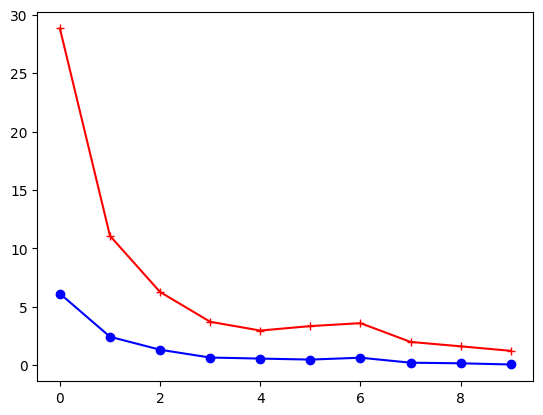

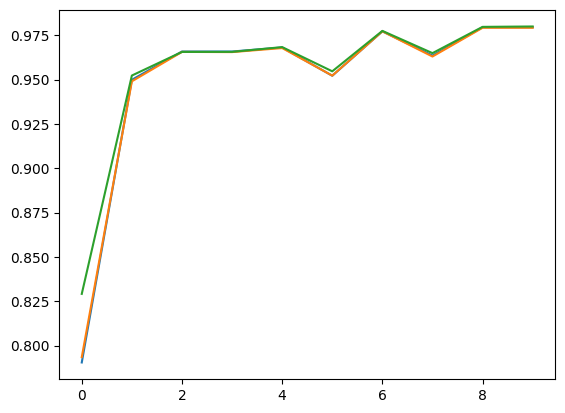

In [13]:
net = SimpleNet()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(net.parameters(), lr=1e-3)
# An lr strategy which decreases lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


image_datasets = {'train' : train_dataset, 'val': val_dataset}

dls = {'train' : train_dl, 'val': val_dl}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
train_model(net, dls, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

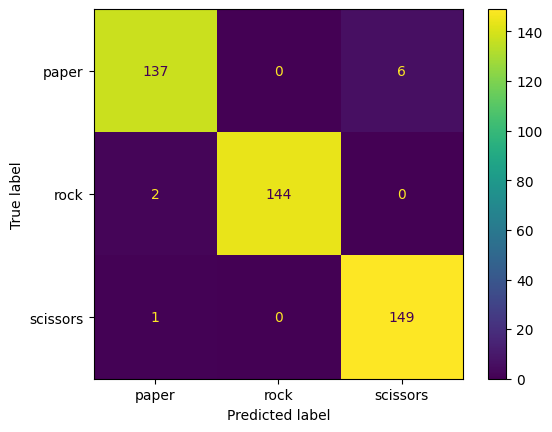

In [14]:
cm_plot(net, val_dl)

Size of tensor containing a batch of images is torch.Size([9, 3, 200, 300])


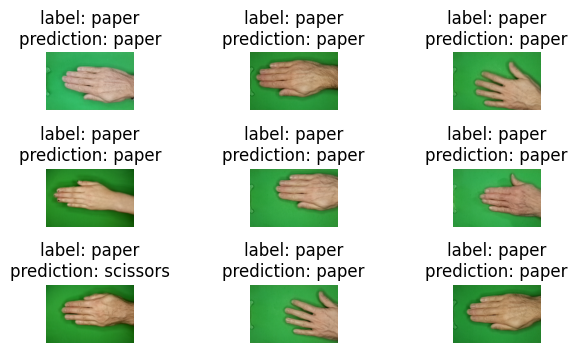

In [15]:
img,lbl=next(iter(val_dl))
inputs = img.to(device).float()
labels = lbl.to(device).float()

print('Size of tensor containing a batch of images is {}'.format(inputs.shape))

with torch.set_grad_enabled(False):
    outputs = net(inputs)


if (device=='cpu'):
    show_batch(img,lbl,outputs)
else:
    show_batch(img,lbl,outputs.cpu().numpy())

